In [ ]:
!pip install googletrans

In [ ]:
import tweepy
import csv
import re
from textblob import TextBlob
import pandas as pd
from googletrans import Translator
import time
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from wordcloud import WordCloud, STOPWORDS

In [ ]:
#Keys from Twitter Developer Account
key = key
secret = secret_key
token = token
token_secret = token_secret

In [ ]:
#Authorising keys and making them useable
auth = tweepy.OAuthHandler(key, secret)
auth.set_access_token(token, token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
queries = ['@DojaCat', '#DojaCat', '#dojacat', '#Doja_Cat', '#doja_cat']
ql = len(queries)
ql

In [ ]:
#Complete loop for data collection & Storing in a csv file
tweet_list = []
header = ['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang','retweeted_status', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'withheld_scope', 'withheld_in_countries']
file = open('TSA_Data.csv', 'w', newline ='')
with file:
  writer = csv.DictWriter(file, fieldnames = header) 
  writer.writeheader()

for c in range (100):
  for i in range(ql):
    search_result = api.search(q=queries[i], count = 100, tweet_mode = 'extended')  
    for i in search_result:    
      tweet_list.append(i._json)   
      file = open('TSA_Data.csv', 'a', newline ='')    
      with file:      
        writer = csv.DictWriter(file, fieldnames = header)       
        writer.writerow(i._json)
  time.sleep(15*60)

In [ ]:
tsa = pd.read_csv('TSA_Data.csv')

In [ ]:
tsa.shape

(6218, 34)

In [ ]:
#Steps to drop repeated and duplicate rows
tsa.sort_values('id', ignore_index=True, inplace=True)
tsa.drop_duplicates(subset='id', keep=False, inplace=True)

In [ ]:
tsa.shape

(211, 34)

In [ ]:
tsa.to_csv('TSA_DC.csv')

In [ ]:
data  = pd.read_csv('TSA_DC.csv', parse_dates=['created_at'])

In [ ]:
data.shape

(211, 7)

In [ ]:
#Function to extract user ids from strings and to create new dataset with required columns
def user_id(df):
  df['user_id'] = pd.DataFrame((data.user.str.split(expand=True)[1]).str.split(",", expand=True)[0])
  df['user_id'] = df['user_id'].astype(int)
  df.sort_values('user_id', inplace=True, ignore_index=True)
  df = df[['user_id','id','full_text','lang','retweet_count']]
  return df

In [ ]:
#Functions to perform sentiment analysis and to merge the old dataset and new sentiment dataset
def clean_tweet(data, tweet):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

translator = Translator()
def translate(word):
  return translator.translate(word, dest='en').text

def get_tweet_sentiment(data, tweet):
  analysis = TextBlob(clean_tweet(data, translate(tweet)))
  if (analysis.sentiment.polarity>0):
    return 'positive'
  elif (analysis.sentiment.polarity == 0):
    return 'neutral'
  else:
    return 'negative'

def get_tweets(data):
  tweets = []
  count = 0
  for tweet in data.full_text:
    parsed_tweet = {}
    parsed_tweet['text'] = tweet
    parsed_tweet['sentiment'] = get_tweet_sentiment(data, translate(tweet))
    tweets.append(parsed_tweet)
    count+=1
  return tweets

In [ ]:
#New dataframe having only text and its sentiment
df = user_id(data)

var = get_tweets(df)
fsa = pd.DataFrame(var)
fsa.to_csv('Final_Sentiment_Analysis.csv')

In [ ]:
fsa.head()

,Unnamed: 0,text,sentiment
0,0,@DojaCat Attention time,neutral
1,1,I want to eat @DojaCat ass,neutral
2,2,RT @girlsinrap: Most Viewed Female Rappers On ...,positive
3,3,@LadySs @CapitalXTRA @DojaCat @ShaynaTMarie yo...,neutral
4,4,Another brand new one for #OffTheGrill899! @An...,positive


In [ ]:
data.keys()

Index(['Unnamed: 0', 'created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
       'retweeted_status', 'quoted_status', 'quoted_status_id',
       'quoted_status_id_str', 'withheld_scope', 'withheld_in_countries',
       'user_id'],
      dtype='object')

In [ ]:
df.keys()

Index(['user_id', 'id', 'full_text', 'lang', 'retweet_count'], dtype='object')

In [ ]:
#Function to drop unnecessary columns and add required columns
def new_data(df, senti):
  df['user_id'] = pd.DataFrame((data.user.str.split(expand=True)[1]).str.split(",",expand=True)[0])
  df['user_id'] = df['user_id'].astype(int)
  df.sort_values('user_id', inplace=True)
  df = pd.concat([df,senti], axis=1, join='inner')
  df = df[['user_id','id','created_at','full_text','user','retweet_count','sentiment']]
  return df

In [ ]:
data = new_data(data, fsa)
ff = data.groupby(by=['user_id','id'])
grouped_data = pd.DataFrame(ff.first())

In [ ]:
grouped_data.keys()

Index(['created_at', 'full_text', 'user', 'retweet_count', 'sentiment'], dtype='object')

In [ ]:
#Function to find out max followers count of every user
def followers_count(grouped_data):
  ll = []
  l=[]
  lol=[]
  for i in range(len(grouped_data)):
    if (grouped_data['user'].index[i][0]!=grouped_data['user'].index[-1][0] and grouped_data['user'].index[i][0]==grouped_data['user'].index[i+1][0]):
      res = ast.literal_eval(grouped_data.user[i])
      l = [lol.append(v) for k,v in res.items() if k=='followers_count']
    elif (grouped_data['user'].index[i][0]!=grouped_data['user'].index[-1][0] and grouped_data['user'].index[i][0]!=grouped_data['user'].index[i+1][0]):
      res = ast.literal_eval(grouped_data.user[i])
      l = [lol.append(v) for k,v in res.items() if k=='followers_count']
      lol.sort()
      ll.append(lol[-1])
      lol = []
    elif (i==(len(grouped_data.index))-1):
      res = ast.literal_eval(grouped_data.user[i])
      l = [lol.append(v) for k,v in res.items() if k=='followers_count']
      lol.sort()
      ll.append(lol[-1])
      break
    elif (grouped_data['created_at'].index[i][0]==grouped_data['created_at'].index[-1][0]):
      res = ast.literal_eval(grouped_data.user[i])
      l = [lol.append(v) for k,v in res.items() if k=='followers_count']
  return ll

In [ ]:
#Function to find out max retweet count of every user
def retweet_count(grouped_data):
  ll = []
  l=[]
  for i in range(len(grouped_data)):
    if (grouped_data['retweet_count'].index[i][0]!=grouped_data['retweet_count'].index[-1][0] and  grouped_data['retweet_count'].index[i][0]==grouped_data['retweet_count'].index[i+1][0]):
      l.append((grouped_data['retweet_count'][i]).astype(int))
    elif (grouped_data['retweet_count'].index[i][0]!=grouped_data['retweet_count'].index[-1][0] and grouped_data['retweet_count'].index[i][0]!=grouped_data['retweet_count'].index[i+1][0]):
      l.append((grouped_data['retweet_count'][i]).astype(int))
      l.sort()
      ll.append(l[-1])
      l = []
    elif (i==(len(grouped_data.index))-1):
      l.append((grouped_data['retweet_count'][i]).astype(int))
      l.sort()
      ll.append(l[-1])
      break
    elif (grouped_data['retweet_count'].index[i][0]==grouped_data['retweet_count'].index[-1][0]):
      l.append((grouped_data['retweet_count'][i]).astype(int))
  return ll

In [ ]:
sentii = {'positive':1, 'neutral':0, 'negative':-1}
grouped_data['sentiment'] = grouped_data['sentiment'].map(sentii)

In [ ]:
#Function to calculate sentiment score of every user
def sentiment_score(grouped_data):
  ll = []
  l = []
  v = 0
  for i in range(len(grouped_data)):
    if (grouped_data['sentiment'].index[i][0]!=grouped_data['sentiment'].index[-1][0] and grouped_data['sentiment'].index[i][0]==grouped_data['sentiment'].index[i+1][0]):
      l.append(grouped_data['sentiment'][i].astype(int))
    elif (grouped_data['sentiment'].index[i][0]!=grouped_data['sentiment'].index[-1][0] and grouped_data['sentiment'].index[i][0]!=grouped_data['sentiment'].index[i+1][0]):
      l.append(grouped_data['sentiment'][i].astype(int))
      v = sum(l)
      ll.append(v)
      l = []
      v = 0
    elif (i==(len(grouped_data.index))-1):
      l.append(grouped_data['sentiment'][i].astype(int))
      v = sum(l)
      ll.append(v)
      break
    elif (grouped_data['sentiment'].index[i][0]==grouped_data['sentiment'].index[-1][0]):
      l.append(grouped_data['sentiment'][i].astype(int))
  return ll

In [ ]:
#Function to find out the average sentiment of every user
def sentiment(grouped_data):
  ss = []
  for i in range(len(grouped_data)):
    if grouped_data.sentiment_score[i] > 0:
      ss.append('positive')
    elif grouped_data.sentiment_score[i] < 0:
      ss.append('negative')
    else:
      ss.append('neutral')
  return ss

In [ ]:
tt = pd.DataFrame()
tt['user_id'] = data.user_id.unique()
tt['followers_count'] = followers_count(grouped_data)
tt['retweet_count'] = retweet_count(grouped_data)
tt['sentiment_score'] = sentiment_score(grouped_data)
tt['sentiment'] = sentiment(tt)

In [ ]:
tt.head()

,user_id,followers_count,retweet_count,sentiment_score,sentiment
0,48871957,180,0,0,neutral
1,92458611,396,0,0,neutral
2,147218661,2361,76,1,positive
3,220192865,16553,0,0,neutral
4,289856832,2909,0,1,positive


In [ ]:
tt.describe()

,user_id,followers_count,retweet_count,sentiment_score
count,1.530000e+02,153.000000,153.000000,153.000000
mean,8.763589e+17,1143.261438,574.437908,0.235294
std,5.064745e+17,5094.447567,2811.013270,0.864236
min,4.887196e+07,0.000000,0.000000,-5.000000
25%,7.534675e+17,41.000000,0.000000,0.000000
50%,1.144692e+18,222.000000,2.000000,0.000000
75%,1.257140e+18,474.000000,168.000000,1.000000
max,1.286637e+18,45246.000000,32989.000000,2.000000


In [ ]:
print('Neutral tweets percentage: {} %'.format(nt))
print('Positive tweets percentage: {} %'.format(p))
print('Negative tweets percentage: {} %'.format(n))

Neutral tweets percentage: 49.01960784313725 %
Positive tweets percentage: 38.56209150326798 %
Negative tweets percentage: 12.418300653594772 %


In [ ]:
p=(len(tt[tt['sentiment']=='positive'])/len(tt))*100
n=(len(tt[tt['sentiment']=='negative'])/len(tt))*100
nt=(len(tt[tt['sentiment']=='neutral'])/len(tt))*100
fig = go.Figure(go.Funnelarea(text =['Neutral','Positive','Negative'],values =[nt,p,n] ,title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}))
fig.show()

In [ ]:
fig = go.Figure(go.Funnel(y = ['Neutral','Positive','Negative'], x = [nt,p,n],textposition = "inside",opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],"line": {"width": [4, 2, 2, 3], "color": ["wheat", "wheat", "blue"]}},connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}))
fig.show()

Text(0, 0.5, 'No. of users')

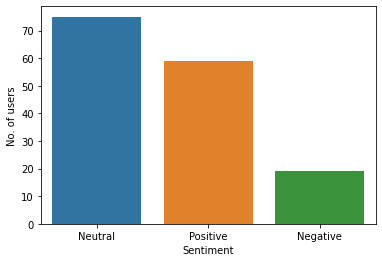

In [ ]:
l=tt[tt['sentiment']=='neutral']
l2=tt[tt['sentiment']=='positive']
l3=tt[tt['sentiment']=='negative']
y=[len(l),len(l2),len(l3)]
x=['Neutral','Positive','Negative']
at=sns.barplot(x,y)
plt.xlabel('Sentiment')
plt.ylabel('No. of users')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



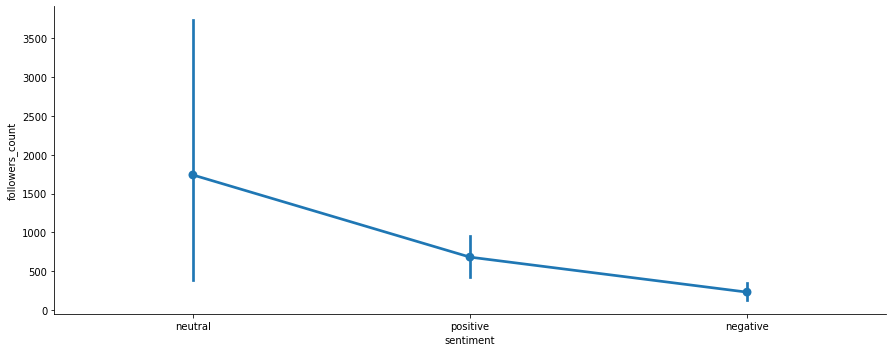

In [ ]:
axes = sns.factorplot('sentiment','followers_count',data=tt, aspect = 2.5)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



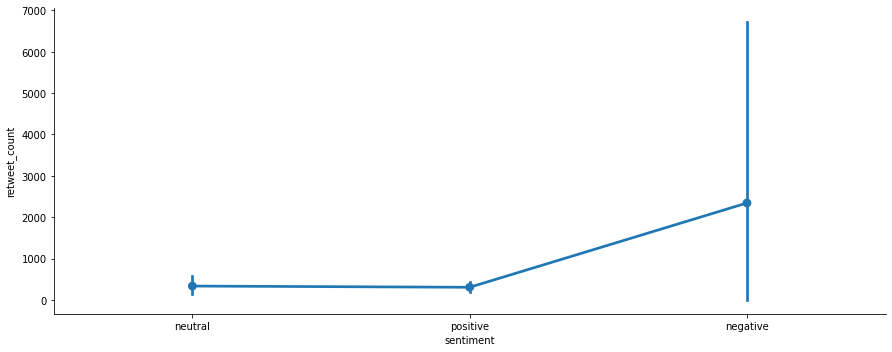

In [ ]:
axes = sns.factorplot('sentiment','retweet_count',data=tt, aspect = 2.5)

In [ ]:
#Functions to clean out the tweets for word cloud
def clean_tweet(tweet):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(RT)|(RAT)|(\w+:\/\/\S+)", " ", tweet).split())

translator = Translator()
def translate(word):
  return translator.translate(word, dest='en').text

In [ ]:
tc=[]
for i in df.full_text:
  tc.append(clean_tweet(translate(i)))

In [ ]:
new = pd.DataFrame(tc)

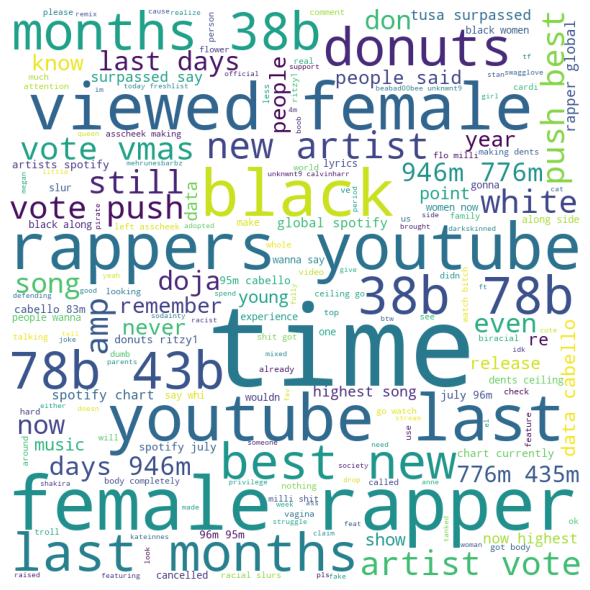

In [ ]:
#To generate word cloud
comment_words = '' 
stopwords = set(STOPWORDS) 
for val in new[0]: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

In [ ]:
Thank You!